In [1]:
import deepcell
import syotil

import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import MSE

from deepcell.utils.train_utils import rate_scheduler, get_callbacks, count_gpus
from deepcell.losses import weighted_categorical_crossentropy
from deepcell.model_zoo.panopticnet import PanopticNet
from deepcell_toolbox.deep_watershed import deep_watershed

In [2]:
base_url = ('https://deepcell-data.s3-us-west-1.amazonaws.com/'
            'demos/janelia/hela_s3_{}_256.npz')

nuclear = deepcell.datasets.Dataset(
    path='nuclear.npz',
    url=base_url.format('nuclear'),
    file_hash='04a200f437aa2f7c66d636c84c379ba7',
    metadata=None
)

fluo_cyto = deepcell.datasets.Dataset(
    path='fluo_cyto.npz',
    url=base_url.format('fluo_cyto'),
    file_hash='6a8a3ba4ddf3de8bb90776fa41a5a664',
    metadata=None
)

phase = deepcell.datasets.Dataset(
    path='phase.npz',
    url=base_url.format('phase'),
    file_hash='c56df51039fe6cae15c818118dfb8ce8',
    metadata=None
)

In [4]:
from deepcell import image_generators

dataset = fluo_cyto  # Change this to another dataset! (nuclear, phase, fluo_cyto)

min_objects = 2

test_size = 0.2 # fraction of data saved as test
seed = 0 # seed for random train-test split

(X_train, y_train), (X_test, y_test) = dataset.load_data(
    test_size=test_size, seed=seed)

print('X_train.shape: {}\nX_test.shape: {}'.format(
    X_train.shape, X_test.shape))
transforms = ['inner-distance', 'outer-distance', 'fgbg']
transforms_kwargs = {'outer-distance': {'erosion_width': 0}}


# use augmentation for training but not validation
datagen = image_generators.SemanticDataGenerator(
    rotation_range=180,
    fill_mode='reflect',
    zoom_range=(0.75, 1.25),
    horizontal_flip=True,
    vertical_flip=True)

datagen_val = image_generators.SemanticDataGenerator()

batch_size = 8

train_data = datagen.flow(
    {'X': X_train, 'y': y_train},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_data = datagen_val.flow(
    {'X': X_test, 'y': y_test},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

X_train.shape: (1872, 256, 256, 1)
X_test.shape: (468, 256, 256, 1)


In [5]:
semantic_classes = [1, 1, 2] # inner distance, outer distance, fgbg

model = PanopticNet(
    backbone='resnet50',
    input_shape=X_train.shape[1:],
    norm_method='whole_image',
    num_semantic_classes=semantic_classes)

n_epoch = 5

lr = 1e-4
optimizer = Adam(lr=lr, clipnorm=0.001)
lr_sched = rate_scheduler(lr=lr, decay=0.99)

# Create a dictionary of losses for each semantic head

def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        if n_classes > 1:
            return 0.01 * weighted_categorical_crossentropy(
                y_pred, y_true, n_classes=n_classes)
        return MSE(y_pred, y_true)
    return _semantic_loss

loss = {}

# Give losses for all of the semantic heads
for layer in model.layers:
    if layer.name.startswith('semantic_'):
        n_classes = layer.output_shape[-1]
        loss[layer.name] = semantic_loss(n_classes)
        
model.compile(loss=loss, optimizer=optimizer)

[(layer.name, layer.output_shape) for layer in filter(lambda x: x.name.startswith('semantic_'), model.layers)]

2022-10-10 17:14:05.689177: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
2022-10-10 17:14:07.038787: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10429 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:5e:00.0, compute capability: 6.1
/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [6]:
# fit the model
from deepcell.utils.train_utils import get_callbacks
from deepcell.utils.train_utils import count_gpus

model_name = 'phase_deep_watershed'
model_path = '{}.h5'.format(model_name)

print('Training on', count_gpus(), 'GPUs.')

train_callbacks = get_callbacks(
    model_path,
    lr_sched=lr_sched,
    monitor='val_loss',
    verbose=1)

loss_history = model.fit(
    train_data,
    steps_per_epoch=train_data.y.shape[0] // batch_size,
    epochs=n_epoch,
    validation_data=val_data,
    validation_steps=val_data.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Training on 1 GPUs.


2022-10-10 17:14:38.548972: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 10429 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:5e:00.0, compute capability: 6.1


Epoch 1/5


2022-10-10 17:14:53.259875: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8202


234/234 [==============================] - ETA: 0s - loss: 0.0251 - semantic_0_loss: 0.0076 - semantic_1_loss: 0.0158 - semantic_2_loss: 0.0017
Epoch 00001: val_loss improved from inf to 0.05939, saving model to phase_deep_watershed.h5


/app/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


234/234 [==============================] - 85s 288ms/step - loss: 0.0251 - semantic_0_loss: 0.0076 - semantic_1_loss: 0.0158 - semantic_2_loss: 0.0017 - val_loss: 0.0594 - val_semantic_0_loss: 0.0038 - val_semantic_1_loss: 0.0465 - val_semantic_2_loss: 0.0091 - lr: 1.0000e-04
Epoch 2/5
234/234 [==============================] - ETA: 0s - loss: 0.0084 - semantic_0_loss: 0.0021 - semantic_1_loss: 0.0056 - semantic_2_loss: 7.7318e-04
Epoch 00002: val_loss improved from 0.05939 to 0.02419, saving model to phase_deep_watershed.h5
234/234 [==============================] - 69s 292ms/step - loss: 0.0084 - semantic_0_loss: 0.0021 - semantic_1_loss: 0.0056 - semantic_2_loss: 7.7318e-04 - val_loss: 0.0242 - val_semantic_0_loss: 0.0030 - val_semantic_1_loss: 0.0179 - val_semantic_2_loss: 0.0033 - lr: 9.9000e-05
Epoch 3/5
234/234 [==============================] - ETA: 0s - loss: 0.0074 - semantic_0_loss: 0.0019 - semantic_1_loss: 0.0048 - semantic_2_loss: 6.8404e-04
Epoch 00003: val_loss improved

In [23]:
# create prediction model

from deepcell.model_zoo.panopticnet import PanopticNet

prediction_model = PanopticNet(
    backbone='resnet50',
    norm_method='whole_image',
    num_semantic_classes=[1, 1], # inner distance, outer distance
    input_shape=X_train.shape[1:]
)

prediction_model.load_weights(model_path, by_name=True)

In [26]:
# make predictions on testing data
from timeit import default_timer

start = default_timer()
test_images = prediction_model.predict(X_test)
watershed_time = default_timer() - start

print('Watershed segmentation of shape', test_images[0].shape,
      'in', watershed_time, 'seconds.')

from deepcell_toolbox.deep_watershed import deep_watershed

masks = deep_watershed(
    test_images,
    min_distance=10,
    detection_threshold=0.1,
    distance_threshold=0.01,
    exclude_border=False,
    small_objects_threshold=0)


Watershed segmentation of shape (468, 256, 256, 1) in 3.423900566995144 seconds.


In [27]:
syotil.csi(y_test[0,:,:,0], masks[0,:,:,0])

0.8333333333333334

In [12]:
# read CD3 data

from skimage import io
img=io.imread("images/square_patches/M872956_JML_Position8_CD3_img_patch256x256.png")
print(img.shape)
X_cd3=img[:,:,2]
#io.imshow(im)
#plt.show()
X_cd3=np.expand_dims(X_cd3, -1) 
X_cd3=np.expand_dims(X_cd3, 0) 

y_cd3=io.imread("images/square_patches/M872956_JML_Position8_CD3_masks_patch256x256.png")
print(y_cd3.shape)
#io.imshow(mask_true)
#plt.show()
y_cd3=np.expand_dims(y_cd3, -1) 
y_cd3=np.expand_dims(y_cd3, 0) 

batch_size = 1

train_cd3 = datagen.flow(
    {'X': X_cd3, 'y': y_cd3},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

val_cd3 = datagen_val.flow(
    {'X': X_cd3, 'y': y_cd3},
    seed=seed,
    transforms=transforms,
    transforms_kwargs=transforms_kwargs,
    min_objects=min_objects,
    batch_size=batch_size)

(256, 256, 3)
(256, 256)


In [24]:
# make predictions on CD3 data
from timeit import default_timer

start = default_timer()
test_images = prediction_model.predict(X_cd3)
watershed_time = default_timer() - start

from deepcell_toolbox.deep_watershed import deep_watershed

pred_cd3 = deep_watershed(
    test_images,
    min_distance=0,
    detection_threshold=0.001,
    distance_threshold=0.0,
    exclude_border=False,
    small_objects_threshold=0)


(1, 256, 256, 1) (1, 256, 256, 1)


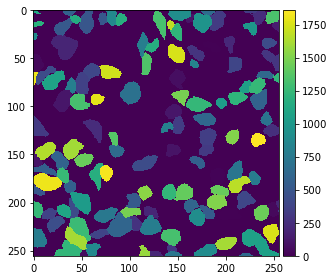

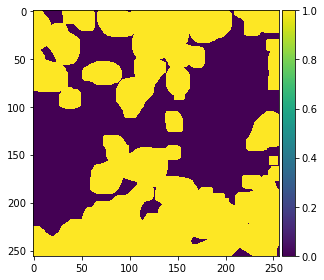

0.0

In [25]:
print(y_cd3.shape, pred_cd3.shape)
io.imshow(y_cd3[0,:,:,0])
plt.show()
io.imshow(pred_cd3[0,:,:,0])
plt.show()
syotil.csi(y_cd3[0,:,:,0], pred_cd3[0,:,:,0])
# the cyto_fluo training data cells are bigger than CD3 cells

In [22]:
# fit again with K data

loss_history = model.fit(
    train_cd3,
    steps_per_epoch=train_cd3.y.shape[0] // batch_size,
    epochs=100,
    validation_data=val_cd3,
    validation_steps=val_cd3.y.shape[0] // batch_size,
    callbacks=train_callbacks)

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 0.0817 - semantic_0_loss: 0.0296 - semantic_1_loss: 0.0470 - semantic_2_loss: 0.0051
Epoch 00001: val_loss did not improve from 0.00643
1/1 [==============================] - 0s 328ms/step - loss: 0.0817 - semantic_0_loss: 0.0296 - semantic_1_loss: 0.0470 - semantic_2_loss: 0.0051 - val_loss: 0.0999 - val_semantic_0_loss: 0.0418 - val_semantic_1_loss: 0.0529 - val_semantic_2_loss: 0.0052 - lr: 1.0000e-04
Epoch 2/100
1/1 [==============================] - ETA: 0s - loss: 0.0953 - semantic_0_loss: 0.0352 - semantic_1_loss: 0.0543 - semantic_2_loss: 0.0057
Epoch 00002: val_loss did not improve from 0.00643
1/1 [==============================] - 0s 262ms/step - loss: 0.0953 - semantic_0_loss: 0.0352 - semantic_1_loss: 0.0543 - semantic_2_loss: 0.0057 - val_loss: 0.0970 - val_semantic_0_loss: 0.0409 - val_semantic_1_loss: 0.0511 - val_semantic_2_loss: 0.0049 - lr: 9.9000e-05
Epoch 3/100
1/1 [==============================] -

1/1 [==============================] - ETA: 0s - loss: 0.0575 - semantic_0_loss: 0.0213 - semantic_1_loss: 0.0332 - semantic_2_loss: 0.0030
Epoch 00035: val_loss did not improve from 0.00643
1/1 [==============================] - 0s 271ms/step - loss: 0.0575 - semantic_0_loss: 0.0213 - semantic_1_loss: 0.0332 - semantic_2_loss: 0.0030 - val_loss: 0.0560 - val_semantic_0_loss: 0.0255 - val_semantic_1_loss: 0.0274 - val_semantic_2_loss: 0.0031 - lr: 7.1055e-05
Epoch 36/100
1/1 [==============================] - ETA: 0s - loss: 0.0615 - semantic_0_loss: 0.0238 - semantic_1_loss: 0.0341 - semantic_2_loss: 0.0037
Epoch 00036: val_loss did not improve from 0.00643
1/1 [==============================] - 0s 262ms/step - loss: 0.0615 - semantic_0_loss: 0.0238 - semantic_1_loss: 0.0341 - semantic_2_loss: 0.0037 - val_loss: 0.0555 - val_semantic_0_loss: 0.0254 - val_semantic_1_loss: 0.0271 - val_semantic_2_loss: 0.0030 - lr: 7.0345e-05
Epoch 37/100
1/1 [==============================] - ETA: 0s -

1/1 [==============================] - ETA: 0s - loss: 0.0491 - semantic_0_loss: 0.0185 - semantic_1_loss: 0.0278 - semantic_2_loss: 0.0028
Epoch 00069: val_loss did not improve from 0.00643
1/1 [==============================] - 0s 266ms/step - loss: 0.0491 - semantic_0_loss: 0.0185 - semantic_1_loss: 0.0278 - semantic_2_loss: 0.0028 - val_loss: 0.0500 - val_semantic_0_loss: 0.0233 - val_semantic_1_loss: 0.0241 - val_semantic_2_loss: 0.0026 - lr: 5.0489e-05
Epoch 70/100
1/1 [==============================] - ETA: 0s - loss: 0.0480 - semantic_0_loss: 0.0187 - semantic_1_loss: 0.0265 - semantic_2_loss: 0.0028
Epoch 00070: val_loss did not improve from 0.00643
1/1 [==============================] - 0s 266ms/step - loss: 0.0480 - semantic_0_loss: 0.0187 - semantic_1_loss: 0.0265 - semantic_2_loss: 0.0028 - val_loss: 0.0500 - val_semantic_0_loss: 0.0233 - val_semantic_1_loss: 0.0241 - val_semantic_2_loss: 0.0026 - lr: 4.9984e-05
Epoch 71/100
1/1 [==============================] - ETA: 0s -